In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
from pathlib import Path
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline

In [2]:
data_folder = Path("/home/aniket/Music/notebooks/data/titanic")

In [3]:
train_data = pd.read_csv(data_folder/"train.csv")
test_data = pd.read_csv(data_folder/"test.csv")

#test_label = pd.read_csv(data_folder/"gender_submission.csv")

In [4]:
#test_data = test_data.set_index('PassengerId').join(test_label.set_index('PassengerId'))
#test_data.reset_index(inplace=True)

test_data.head()

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
pat = '\s([A-Za-z]+)\.'

In [7]:
train_data['title'] = train_data['Name'].str.extract(pat = pat)
test_data['title'] = test_data['Name'].str.extract(pat = pat)

In [8]:
train_data['title'] = train_data.title.map(defaultdict(lambda: 3,Mr= 0, Mrs= 1, Miss= 2),na_action='ignore')
test_data['title'] = test_data.title.map(defaultdict(lambda: 3,Mr= 0, Mrs= 1, Miss= 2),na_action='ignore')

In [9]:
train_data[['Pclass','Fare']].groupby(['Pclass'],as_index=False).mean()

,Pclass,Fare
0,1,84.154687
1,2,20.662183
2,3,13.675550


In [10]:
train_data['FamilyMembers'] = train_data['SibSp'] + train_data['Parch'] 
test_data['FamilyMembers'] = test_data['SibSp'] + test_data['Parch'] 


In [11]:
train_data.groupby('SibSp').size()

SibSp
0    608
1    209
2     28
3     16
4     18
5      5
8      7
dtype: int64

In [12]:
train_data.loc[train_data['FamilyMembers'] == 0, 'solo'] = 1
train_data.loc[train_data['FamilyMembers'] > 0, 'solo'] = 0

test_data.loc[train_data['FamilyMembers'] == 0, 'solo'] = 1
test_data.loc[train_data['FamilyMembers'] > 0, 'solo'] = 0

In [13]:
train_data.groupby('SibSp').size()

SibSp
0    608
1    209
2     28
3     16
4     18
5      5
8      7
dtype: int64

In [14]:
age_labels=['A1','A2','A3','A4','A5']
age_bins=[0,15,30,45,65,99]
category = pd.cut(train_data.Age,bins=age_bins,labels=age_labels)
train_data.insert(5,'AgeGroup',category)


fare_bins=[0,25,50,1000]
fare_labels=['Low','Mid','High']
category = pd.cut(train_data.Fare,bins=fare_bins,labels=fare_labels)
train_data.insert(6,'FareGroup',category)

familyMembers_bins=[-1,0,1,2,100]
familyMembers_labels=['F1','F2','F3','F4']
category = pd.cut(train_data.FamilyMembers,bins=familyMembers_bins,labels=familyMembers_labels)
train_data.insert(6,'FamilyMembersGroup',category)

parch_bins=[-1,0,1,2,100]
parch_labels=['1','2','3','4']
category = pd.cut(train_data.Parch,bins=parch_bins,labels=parch_labels)
train_data.insert(6,'ParchGroup',category)

sibSp_bins=[-1,0,1,2,100]
sibSp_labels=['1','2','3','4']
category = pd.cut(train_data.SibSp,bins=sibSp_bins,labels=sibSp_labels)
train_data.insert(6,'SibSpGroup',category)

In [15]:
category = pd.cut(test_data.Age,bins=age_bins,labels=age_labels)
test_data.insert(5,'AgeGroup',category)

category = pd.cut(test_data.Fare,bins=fare_bins,labels=fare_labels)
test_data.insert(6,'FareGroup',category)

category = pd.cut(test_data.FamilyMembers,bins=familyMembers_bins,labels=familyMembers_labels)
test_data.insert(7,'FamilyMembersGroup',category)

category = pd.cut(test_data.Parch,bins=parch_bins,labels=parch_labels)
test_data.insert(6,'ParchGroup',category)

category = pd.cut(test_data.SibSp,bins=sibSp_bins,labels=sibSp_labels)
test_data.insert(6,'SibSpGroup',category)

In [16]:
train_data.tail()

,PassengerId,Survived,Pclass,Name,Sex,AgeGroup,SibSpGroup,ParchGroup,FamilyMembersGroup,FareGroup,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title,FamilyMembers,solo
886,887,0,2,"Montvila, Rev. Juozas",male,A2,1,1,F1,Low,27.0,0,0,211536,13.00,NaN,S,3,0,1.0
887,888,1,1,"Graham, Miss. Margaret Edith",female,A2,1,1,F1,Mid,19.0,0,0,112053,30.00,B42,S,2,0,1.0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,2,3,F4,Low,NaN,1,2,W./C. 6607,23.45,NaN,S,2,3,0.0
889,890,1,1,"Behr, Mr. Karl Howell",male,A2,1,1,F1,Mid,26.0,0,0,111369,30.00,C148,C,0,0,1.0
890,891,0,3,"Dooley, Mr. Patrick",male,A3,1,1,F1,Low,32.0,0,0,370376,7.75,NaN,Q,0,0,1.0


In [17]:
train_data[['Fare','Pclass']].groupby('Pclass').std()

,Fare
Pclass,
1,78.380373
2,13.417399
3,11.778142


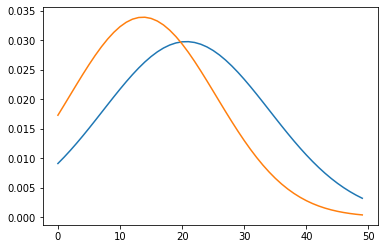

In [18]:
x_axis = np.arange(0, 50, 1)
plt.plot(norm.pdf(x_axis,20.662183,13.417399),label = 'Pclass2')
plt.plot(norm.pdf(x_axis,13.675550,11.778142),label = 'Pclass3')

In [19]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'AgeGroup',
       'SibSpGroup', 'ParchGroup', 'FamilyMembersGroup', 'FareGroup', 'Age',
       'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'title',
       'FamilyMembers', 'solo'],
      dtype='object')

In [20]:
train_data.replace([np.inf, -np.inf], np.nan,inplace=True)
test_data.replace([np.inf, -np.inf], np.nan,inplace=True)

In [21]:
features_used_to_train = ['Pclass','Sex','Embarked', 'AgeGroup','FareGroup','ParchGroup','SibSpGroup']

In [22]:
X = train_data[features_used_to_train]
X_pred = test_data[features_used_to_train]

In [23]:
y = train_data['Survived']
#Y_test = test_data['Survived']

In [24]:
X.head()

,Pclass,Sex,Embarked,AgeGroup,FareGroup,ParchGroup,SibSpGroup
0,3,male,S,A2,Low,1,2
1,1,female,C,A3,High,1,2
2,3,female,S,A2,Low,1,1
3,1,female,S,A3,High,1,2
4,3,male,S,A3,Low,1,1


In [25]:
numericalColumns = [
    
]

categoricalColumns = [
    "Pclass",
    "Sex",
    "Embarked",
    'AgeGroup',
    'FareGroup',
    'ParchGroup',
    'SibSpGroup'
]

In [26]:
#imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
#imp_most_frequent = SimpleImputer(missing_values=np.nan, ,strategy='most_frequent')
ctImputer = ColumnTransformer([
                        ("Imputer1", SimpleImputer(missing_values=np.nan, strategy='most_frequent'),categoricalColumns )
                 #       ,("Imputer2", SimpleImputer(missing_values=np.nan, strategy='median'), numericalColumns)
                        ],
                       remainder="passthrough")

ctEncoder = ColumnTransformer([
                        ("Encoding", OneHotEncoder(),[0,1,2,3,4,5,6])
                        ],
                       remainder="passthrough")

ctNormalization = ColumnTransformer([
                        ("Normalization", MinMaxScaler(),[])
                        ],
                       remainder="passthrough")



In [27]:
X.isna().any()

Pclass        False
Sex           False
Embarked       True
AgeGroup       True
FareGroup      True
ParchGroup    False
SibSpGroup    False
dtype: bool

In [28]:
X= ctImputer.fit_transform(X)

In [29]:
X[0]

array([3, 'male', 'S', 'A2', 'Low', '1', '2'], dtype=object)

In [30]:
X = ctEncoder.fit_transform(X)
X= ctNormalization.fit_transform(X)

In [31]:
X.shape

(891, 24)

In [32]:
#pca = PCA(n_components=10)
pca = TruncatedSVD(15)

In [33]:
X = pca.fit_transform(X)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X
y_train = y

In [35]:
X_pred = ctImputer.transform(X_pred)
X_pred = ctEncoder.transform(X_pred)
X_pred = ctNormalization.transform(X_pred)
X_pred  = pca.transform(X_pred)

In [36]:
#np.where(pd.isnull(X_pred))

In [37]:
#clf = RandomForestClassifier(max_depth=20, random_state=0)
clf = svm.SVC(C=10000,kernel='rbf',gamma=0.001)
#clf = AdaBoostClassifier(n_estimators=20, random_state=0)
#clf = KNeighborsClassifier(n_neighbors=3)

In [38]:
#clf.fit(X_train,y_train)
clf.fit(X_train,y_train)

SVC(C=10000, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [39]:
y_test_pred= clf.predict(X_test)
accuracy_score(y_test,y_test_pred)

0.8156424581005587

In [40]:
scores = cross_val_score(clf,X,y,cv = 5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.82 (+/- 0.04)



y_pred= clf.predict(X_pred)

res = pd.DataFrame({'PassengerId' : test_data['PassengerId'].values,'Survived' : y_pred}
                   ,columns=['PassengerId','Survived'])

res.to_csv(data_folder/"output.csv" , index=False)

In [41]:
mask = ((y_test != y_test_pred) & (y_test == 0))
falsePositive = y_test[mask].index

In [42]:
mask = ((y_test != y_test_pred) & (y_test == 1))
falseNegative = y_test[mask].index

In [43]:
fn_df = train_data.iloc[falseNegative]

In [44]:
fn_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'AgeGroup',
       'SibSpGroup', 'ParchGroup', 'FamilyMembersGroup', 'FareGroup', 'Age',
       'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'title',
       'FamilyMembers', 'solo'],
      dtype='object')

In [45]:
fn_df.groupby(['Pclass','Sex']).size()

Pclass  Sex   
1       male      12
2       male       1
3       female     1
        male       6
dtype: int64

In [46]:
fn_df[['Pclass','Sex','AgeGroup','FareGroup']].sort_values(['Pclass','Sex','AgeGroup','FareGroup'])

,Pclass,Sex,AgeGroup,FareGroup
23,1,male,A2,Mid
889,1,male,A2,Mid
97,1,male,A2,High
447,1,male,A3,Mid
209,1,male,A3,Mid
512,1,male,A3,Mid
604,1,male,A3,Mid
572,1,male,A3,Mid
621,1,male,A3,High
712,1,male,A4,High


In [47]:
var = 'FamilyMembersGroup'
train_data[[var,'Survived']].groupby(var).mean()

,Survived
FamilyMembersGroup,
F1,0.303538
F2,0.552795
F3,0.578431
F4,0.340659


In [48]:
train_data[['Survived']].mean()

Survived    0.383838
dtype: float64

In [49]:
confusion_matrix(y_test, y_test_pred)

array([[92, 13],
       [20, 54]])

In [50]:
len(X_train[0,:])

15

In [51]:
train_data.groupby('Embarked').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,title,FamilyMembers,solo
Embarked,,,,,,,,,,
C,445.357143,0.553571,1.886905,30.814769,0.386905,0.363095,59.954144,0.886905,0.750000,0.505952
Q,417.896104,0.389610,2.909091,28.089286,0.428571,0.168831,13.276030,1.129870,0.597403,0.740260
S,449.527950,0.336957,2.350932,29.445397,0.571429,0.413043,27.079812,0.700311,0.984472,0.610248
